# NEURAL NETWORKS FOR MNIST

##  Importing all

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import idx2numpy

## Define linear layer

In [ ]:
class Linear_layer():
    def __init__(self, input_dimensions, output_dimensions):
        self.W = 2 * np.random.rand(input_dimensions, output_dimensions) - 1
        self.B = np.random.rand(1, output_dimensions)


    def forward(self, x):
        self.x = x
        return x @ self.W + self.B

    def backward(self, error):
        self.dW = self.x.T @ error*0.5
        self.dB = error.sum(axis=0, keepdims=True)   #dCo/dB = error se hace media del error
        return error @ self.W.T

    def update_parameters(self, lr):
        self.W = self.W - lr * self.dW
        self.B = self.B - lr * self.dB


## Define activation layers and input

In [ ]:
class Relu_layer():
    def __init__(self):
        pass

    def forward(self, x):
        self.Z = np.maximum(0,x)
        return self.Z

    def backward(self, error):
        return error * (self.Z > 0)

    def update_parameters(self, learning_rate):
        pass

class Input_layer():
    def __init__(self, input_size):
        self.input_size = input_size

    def forward(self, x):
        return x

    def backward(self, error):
        return error

    def update_parameters(self, learning_rate):
        pass

class Flatten_layer():
    def __init__(self):
        pass
    def forward(self, x):  # x.shape = (bs,28,28) -> (bs. 784)
        return x.reshape(x.shape[0], x.shape[1]*x.shape[2])
    def backward(self, error):
        pass
    def update_parameters(self, learning_rate):
        pass

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims = True))
    return exp_x / np.sum(exp_x, axis=1, keepdims = True)

## Model Design

In [ ]:
class NN_model():
    def __init__(self, input_dimensions, output_dimensions, hidden_dimensions):
        self.sequential = [Flatten_layer(),
                           Input_layer(input_dimensions),
                           Linear_layer(input_dimensions,hidden_dimensions),
                           Relu_layer(),
                           Linear_layer(hidden_dimensions,output_dimensions)]

    def forward(self, x, training=True):
        for layer in self.sequential:
            y = layer.forward(x)  # Recorrer las capas haciendo forward y sacando la salida Y
            x = y                 # La X de la siguiente capa será la Y de la actual

        return softmax(y)

    def backward(self, error):
        for layer in reversed(self.sequential):
            error = layer.backward(error)

        return error

    def update_parameters(self, learning_rate):
        for layer in self.sequential:
            layer.update_parameters(learning_rate)

In [ ]:
class Dataloader():
    def __init__(self,x,y, batch_size, shuffle = True):

        self.batch_size = batch_size
        randomizer = np.arange(len(y))
        if shuffle:
            np.random.shuffle(randomizer)
        self.x = x[randomizer]
        self.y = y[randomizer]

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.x[idx]/255,self.y[idx]

def one_hot(y,num_classes):
    y_encoded = np.zeros((len(y),num_classes))
    y_encoded[np.arange(len(y)), y] = 1
    return y_encoded

In [ ]:
def train(model, dataloader, num_epochs=10, learning_rate=0.1, num_classes=10, verbose = True):
    for epoch in range(num_epochs):
        for i in np.arange(0,len(dataloader),dataloader.batch_size):
            if i+dataloader.batch_size < len(dataloader):
                X_batch, y_batch = dataloader[i:i+dataloader.batch_size]
            else:
                X_batch, y_batch = dataloader[i:len(dataloader)]

            # 0. One_Hot Encoding
            y_real = one_hot(y_batch,num_classes)

            # 1. Forward pass
            y_pred = model.forward(X_batch)

            # 2. Calcular error
            error = -2 * (y_real - y_pred)

            # 3. Backward pass
            model.backward(error)

            # 4. Actualizar parámetros
            model.update_parameters(learning_rate)

        coste = np.mean((y_real - y_pred)**2)
        if verbose:
            print("Coste: ",coste)

        # Imprimir información sobre el progreso del entrenamiento (opcional)
        print(f"Epoch {epoch + 1}/{num_epochs} completada.")

In [ ]:
def test_step(model, X):
    y_pred = model.forward(X)
    return y_pred

def test_loop(model, dataloader, verbose):
    all_preds = []
    all_labels = []

    for i in np.arange(0,len(dataloader),dataloader.batch_size):
        if i+dataloader.batch_size < len(dataloader):
            X_batch, y_batch = dataloader[i:i+dataloader.batch_size]
        else:
            X_batch, y_batch = dataloader[i:len(dataloader)]

        y_pred = test_step(model, X_batch)

        all_preds.append(np.argmax(y_pred, axis=1))
        all_labels.append(y_batch)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Precisión total
    accuracy = np.mean(all_preds == all_labels)
    if verbose:
        print(f"Precisión en test: {accuracy:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    # Visualización
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de Confusión")
    plt.show()


Coste:  0.06556087412326206
Epoch 1/10 completada.
Coste:  0.03981019741481444
Epoch 2/10 completada.
Coste:  0.03979268701249624
Epoch 3/10 completada.
Coste:  0.03951467420676261
Epoch 4/10 completada.
Coste:  0.029316865959089076
Epoch 5/10 completada.
Coste:  0.0330788421833188
Epoch 6/10 completada.
Coste:  0.03642692558508175
Epoch 7/10 completada.
Coste:  0.02724653315504718
Epoch 8/10 completada.
Coste:  0.03447066922785415
Epoch 9/10 completada.
Coste:  0.03707520920203528
Epoch 10/10 completada.
Precisión en test: 0.8886


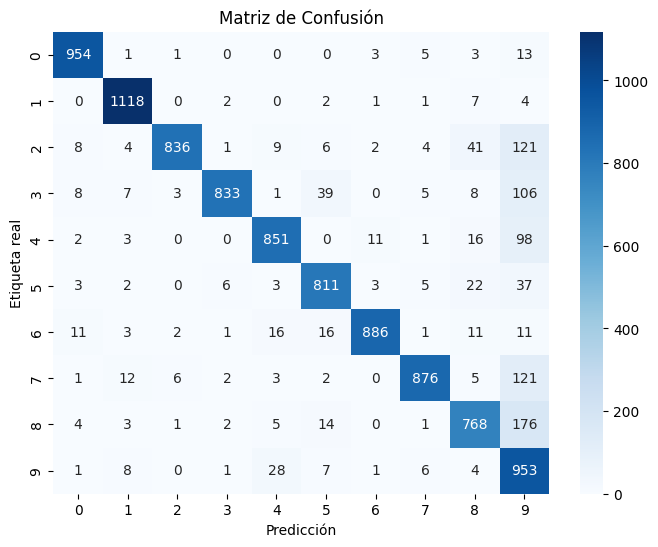

In [ ]:
def main(hidden_dimension = 100, batch_size = 32, learning_rate = 0.03, num_epochs = 10, verbose = True):

    #Importar datos
    train_images, train_labels = 'dataset/train-images.idx3-ubyte', 'dataset/train-labels.idx1-ubyte'
    test_images, test_labels = 'dataset/t10k-images.idx3-ubyte', 'dataset/t10k-labels.idx1-ubyte'

    X_train, X_test = idx2numpy.convert_from_file(train_images), idx2numpy.convert_from_file(test_images)
    y_train, y_test = idx2numpy.convert_from_file(train_labels), idx2numpy.convert_from_file(test_labels)

    #Crear y entrenar el modelo
    model = NN_model(784,10,hidden_dimension)
    dataloader_t = Dataloader(X_train,y_train,batch_size)
    train(model, dataloader_t, num_epochs, learning_rate, 10, verbose)
    test_dataloader = Dataloader(X_test,y_test, batch_size)
    test_loop(model, test_dataloader, verbose)

if __name__ == "__main__":
    # Ejecutar el modelo con los parámetros deseados
    main(hidden_dimension = 100,
        batch_size = 64,
        learning_rate = 0.03,
        num_epochs = 10,
        verbose = True)